#### Copying files from google drive to local runtime for faster execution

In [ ]:
!cp /content/drive/MyDrive/Tobacc800_Groundtruth_v2.0.zip /content/Tobacc800_Groundtruth_v2.0.zip
!cp /content/drive/MyDrive/Tobacco800_SinglePage.zip /content/Tobacco800_SinglePage.zip
!unzip /content/Tobacc800_Groundtruth_v2.0.zip
!unzip /content/Tobacco800_SinglePage.zip

In [2]:
import os, sys, random, shutil
import xml.etree.ElementTree as ET
from glob import glob
import pandas as pd
from shutil import copyfile
import pandas as pd
from sklearn import preprocessing, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

#### Convert Data and getting the annotations that are in an XML file (one XML file per image) and filtering them so as to only train the model to detect images and not logos

In [4]:
df = []
cnt = 0


annotations = sorted(glob('/content/Tobacc800_Groundtruth_v2.0/*.xml'))
for file in annotations:
    myroot = ET.parse(file).getroot()
    prev_filename = myroot[0].attrib['src']
    filename = str(cnt) + '.tif'
    page_height, page_width =  myroot[0][0].attrib['height'], myroot[0][0].attrib['width']
    
    row = []
    for zone in myroot[0][0]:
        category = zone.attrib['gedi_type']
        id = zone.attrib['id']
        x, y = zone.attrib['col'], zone.attrib['row']
        w, h = zone.attrib['width'], zone.attrib['height']
        
        if category == 'DLSignature':
            AuthorID = zone.attrib['AuthorID']
            Overlapped = zone.attrib['Overlapped']
            row = [prev_filename, filename, page_height, page_width, AuthorID, Overlapped, category, id, x, y, w, h]
            df.append(row)
    cnt += 1

In [5]:
data = pd.DataFrame(df, columns=['prev_filename', 'filename', 'page_height', 'page_width', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height'])

In [6]:
data

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height
0,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361
1,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183
2,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206
3,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110
4,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181
...,...,...,...,...,...,...,...,...,...,...,...,...
905,zrt45f00.tif,1283.tif,1575,1200,"Holek, M.L.",Yes,DLSignature,None,514,1019,278,48
906,zrz94a00-page02_2.tif,1285.tif,2156,1728,"Dimech, Ellen",Yes,DLSignature,None,828,1046,362,91
907,zss86d00.tif,1286.tif,2292,1728,"Nielsen, Vigo G.",Yes,DLSignature,None,867,1734,363,189
908,ztz52d00-page02_2.tif,1288.tif,2292,1728,"Bergman, J.I.",Yes,DLSignature,None,896,651,205,178


In [7]:
test = data[['page_height', 'page_width']]
test.max(), test.min()

(page_height    3584
 page_width     2720
 dtype: object, page_height    1575
 page_width     1200
 dtype: object)

#### Scaling the images into the size that yolo expects so that we can give the right sized input for training the yolo model

In [8]:
BASE_DIR = '/content/Tobacco800_SinglePage/'
SAVE_PATH = '/content/scaled/'
os.mkdir(SAVE_PATH)

def scale_image(df):
    df_new = []
    filename = df.prev_filename
    X, Y, W, H = map(int, df.x), map(int, df.y), map(int, df.width), map(int, df.height)
    for file, x, y, w, h in zip(filename, X, Y, W, H):
        image_path = BASE_DIR + file
        img = cv2.imread(image_path, 1)
        page_height, page_width = img.shape[:2]
        max_height = 640
        max_width = 480

        if max_height < page_height or max_width < page_width:
            scaling_factor = max_height / float(page_height)
            if max_width/float(page_width) < scaling_factor:
                scaling_factor = max_width / float(page_width)
            img = cv2.resize(img, None, fx=scaling_factor, fy=scaling_factor, interpolation=cv2.INTER_AREA)
        jpg_filename = file[:-4] + '.jpg'
        new_file_path = SAVE_PATH + jpg_filename
        cv2.imwrite(new_file_path, img)
        
        page_height, page_width = page_height*scaling_factor, page_width*scaling_factor
        x, y, w, h= int(x*scaling_factor), int(y*scaling_factor), int(w*scaling_factor), int(h*scaling_factor)
        row = [jpg_filename, x, y, w, h, page_height, page_width]
        df_new.append(row)
    return df_new
scaled_data = scale_image(data)

In [9]:
scaled_data = list(zip(*scaled_data))

data['new_filename'] = scaled_data[0]
data['x_scaled'] = scaled_data[1]
data['y_scaled'] = scaled_data[2]
data['w_scaled'] = scaled_data[3]
data['h_scaled'] = scaled_data[4]
data['page_height_scaled'] = scaled_data[5]
data['page_width_scaled'] = scaled_data[6]
data.head(10)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
1,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
2,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0
3,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636.666667,480.0
4,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181,acr64d00.jpg,246,500,128,50,636.666667,480.0
5,adh36e00-page2_2.tif,8.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1232,2399,896,431,adh36e00-page2_2.jpg,231,449,168,80,608.625000,480.0
6,adh36e00_2.tif,10.tif,3246,2560,"Krivisky, B.M.",Yes,DLSignature,None,1239,2403,889,434,adh36e00_2.jpg,232,450,166,81,608.625000,480.0
7,adn64a00-page02_3.tif,13.tif,2156,1728,"Koplow, M.G.",Yes,DLSignature,None,871,478,636,152,adn64a00-page02_3.jpg,241,132,176,42,598.888889,480.0
8,adp7aa00.tif,14.tif,3177,2544,"Lisanti, V.F.",No,DLSignature,None,257,2127,549,165,adp7aa00.jpg,48,401,103,31,599.433962,480.0
9,adq65f00.tif,15.tif,1575,1200,"Traviesas, H.",Yes,DLSignature,None,632,810,126,76,adq65f00.jpg,252,324,50,30,630.000000,480.0


In [10]:
data

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
1,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
2,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0
3,abm69c00.tif,5.tif,2292,1728,"Feldman, J.D.",Yes,DLSignature,None,667,1279,617,110,abm69c00.jpg,185,355,171,30,636.666667,480.0
4,acr64d00.tif,6.tif,2292,1728,"Boffa, J.R.",Yes,DLSignature,None,886,1801,463,181,acr64d00.jpg,246,500,128,50,636.666667,480.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,zrt45f00.tif,1283.tif,1575,1200,"Holek, M.L.",Yes,DLSignature,None,514,1019,278,48,zrt45f00.jpg,205,407,111,19,630.000000,480.0
906,zrz94a00-page02_2.tif,1285.tif,2156,1728,"Dimech, Ellen",Yes,DLSignature,None,828,1046,362,91,zrz94a00-page02_2.jpg,230,290,100,25,598.888889,480.0
907,zss86d00.tif,1286.tif,2292,1728,"Nielsen, Vigo G.",Yes,DLSignature,None,867,1734,363,189,zss86d00.jpg,240,481,100,52,636.666667,480.0
908,ztz52d00-page02_2.tif,1288.tif,2292,1728,"Bergman, J.I.",Yes,DLSignature,None,896,651,205,178,ztz52d00-page02_2.jpg,248,180,56,49,636.666667,480.0


#### Test Scaled Image

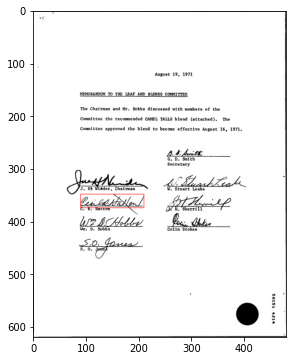

In [11]:
img = cv2.imread('/content/scaled/agw39d00.jpg')

img = cv2.rectangle(img, (90, 348), (90+120, 348+26), (255, 0, 0), 1)
plt.figure(figsize=(6, 6))
plt.imshow(img)

#### Save the scaled coordinated of the signature location to a CSV file

In [12]:
data[['prev_filename', 'new_filename', 'filename', 'page_height', 'page_width', 'page_height_scaled', 'page_width_scaled', 'AuthorID', 'Overlapped', 'category', 'id', 'x', 'y', 'width', 'height', 'x_scaled', 'y_scaled', 'w_scaled', 'h_scaled']].to_csv('/content/tobacco_cleaned.csv', index=False)
data.head(3)

,prev_filename,filename,page_height,page_width,AuthorID,Overlapped,category,id,x,y,width,height,new_filename,x_scaled,y_scaled,w_scaled,h_scaled,page_height_scaled,page_width_scaled
0,aah97e00-page02_2.tif,1.tif,3296,2560,"Boder, J.B.",Yes,DLSignature,None,1409,793,659,361,aah97e00-page02_2.jpg,264,148,123,67,618.000000,480.0
1,aam09c00.tif,2.tif,2292,1728,"Koplow, M.G.",Yes,DLSignature,None,821,1422,757,183,aam09c00.jpg,228,395,210,50,636.666667,480.0
2,aao54e00_2.tif,4.tif,3296,2560,"Landry, J.T.",Yes,DLSignature,None,1514,708,627,206,aao54e00_2.jpg,283,132,117,38,618.000000,480.0


#### Convert Data to Yolo format

In [13]:
def x_center(df):
  return int(df.x_scaled + (df.w_scaled/2))
def y_center(df):
  return int(df.y_scaled + (df.h_scaled/2))

def w_norm(df, col):
  return df[col]/df['page_width_scaled']
def h_norm(df, col):
  return df[col]/df['page_height_scaled']

df = pd.read_csv('/content/tobacco_cleaned.csv')

le = preprocessing.LabelEncoder()
le.fit(df['category'])
print(le.classes_)
labels = le.transform(df['category'])
df['labels'] = labels


df['x_center'] = df.apply(x_center, axis=1)
df['y_center'] = df.apply(y_center, axis=1)

df['x_center_norm'] = df.apply(w_norm, col='x_center',axis=1)
df['width_norm'] = df.apply(w_norm, col='w_scaled', axis=1)

df['y_center_norm'] = df.apply(h_norm, col='y_center',axis=1)
df['height_norm'] = df.apply(h_norm, col='h_scaled',axis=1)

df.head(1)

['DLSignature']


,prev_filename,new_filename,filename,page_height,page_width,page_height_scaled,page_width_scaled,AuthorID,Overlapped,category,...,y_scaled,w_scaled,h_scaled,labels,x_center,y_center,x_center_norm,width_norm,y_center_norm,height_norm
0,aah97e00-page02_2.tif,aah97e00-page02_2.jpg,1.tif,3296,2560,618.0,480.0,"Boder, J.B.",Yes,DLSignature,...,148,123,67,0,325,181,0.677083,0.25625,0.29288,0.108414


In [14]:
df_train, df_valid = model_selection.train_test_split(df, train_size = 0.54,test_size=0.36, shuffle=True)
print(df_train.shape, df_valid.shape)

(491, 26) (328, 26)


In [16]:
os.mkdir('/content/tobacco_yolo_format/')
os.mkdir('/content/tobacco_yolo_format/images/')
os.mkdir('/content/tobacco_yolo_format/images/train/')
os.mkdir('/content/tobacco_yolo_format/images/valid/')

os.mkdir('/content/tobacco_yolo_format/labels/')
os.mkdir('/content/tobacco_yolo_format/labels/train/')
os.mkdir('/content/tobacco_yolo_format/labels/valid/')

#### Segregating the data into train and validation sets so that we can train and validate the model

In [17]:
def segregate_data(df, img_path, train_img_path, train_label_path):
  filenames = []
  for filename in df.filename:
    filenames.append(filename)
  filenames = set(filenames)
  
  for filename in filenames:
    yolo_list = []

    for _,row in df[df.filename == filename].iterrows():
      yolo_list.append([row.labels, row.x_center_norm, row.y_center_norm, row.width_norm, row.height_norm])

    yolo_list = np.array(yolo_list)
    txt_filename = os.path.join(train_label_path,str(row.new_filename.split('.')[0])+".txt")
    np.savetxt(txt_filename, yolo_list, fmt=["%d", "%f", "%f", "%f", "%f"])
    shutil.copyfile(os.path.join(img_path,row.new_filename), os.path.join(train_img_path,row.new_filename))
 
# Apply function
src_img_path = "/content/scaled/"
src_label_path = "/content/groundtruth/"

train_img_path = "/content/tobacco_yolo_format/images/train"
train_label_path = "/content/tobacco_yolo_format/labels/train"

valid_img_path = "/content/tobacco_yolo_format/images/valid"
valid_label_path = "/content/tobacco_yolo_format/labels/valid"

segregate_data(df_train, src_img_path, train_img_path, train_label_path)
segregate_data(df_valid, src_img_path, valid_img_path, valid_label_path)

print("No. of Training images", len(os.listdir('/content/tobacco_yolo_format/images/train')))
print("No. of Training labels", len(os.listdir('/content/tobacco_yolo_format/labels/train')))

print("No. of valid images", len(os.listdir('/content/tobacco_yolo_format/images/valid')))
print("No. of valid labels", len(os.listdir('/content/tobacco_yolo_format/labels/valid')))

No. of Training images 447
No. of Training labels 447
No. of valid images 304
No. of valid labels 304


#### Zipping the pre-processed data so that it can be used to train the yolo model

In [ ]:
!zip -r /content/tobacco_yolo_format.zip /content/tobacco_yolo_format

In [23]:
!cp /content/tobacco_yolo_format.zip /content/drive/MyDrive/